In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import torch
from torchvision import datasets, transforms
import random
import matplotlib.pyplot as plt
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import gc
import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
submission = pd.read_csv('../data/sample_submission.csv')

In [3]:
%%time
X = train[train.columns[1:]].values/255
Y = train.label.values

CPU times: user 285 ms, sys: 231 ms, total: 517 ms
Wall time: 652 ms


In [4]:
print(train.info())
print(np.sum(np.max(train,axis=0)>0))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB
None
709


In [5]:
train_loader = torch.utils.data.DataLoader(
            datasets.MNIST("../datasets", train=True, download=True,
                transform=transforms.Compose([
                    transforms.ToTensor()])), batch_size=60000)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST("../datasets", train=False, download=True,
        transform=transforms.Compose([
            transforms.ToTensor()])), batch_size=10000)
train_data, test_data = list(train_loader), list(test_loader)
images_list = [train_data[0][0].numpy(), test_data[0][0].numpy()]
labels_list = [train_data[0][1].numpy(), test_data[0][1].numpy()]

images = np.concatenate(images_list, axis=0)
labels = np.concatenate(labels_list, axis=0)
idx = list(range(images.shape[0]))
random.shuffle(idx)
images = images[idx]
labels = labels[idx]

Using downloaded and verified file: ../datasets/MNIST/raw/train-images-idx3-ubyte.gz
Extracting ../datasets/MNIST/raw/train-images-idx3-ubyte.gz to ../datasets/MNIST/raw
Using downloaded and verified file: ../datasets/MNIST/raw/train-labels-idx1-ubyte.gz
Extracting ../datasets/MNIST/raw/train-labels-idx1-ubyte.gz to ../datasets/MNIST/raw
Using downloaded and verified file: ../datasets/MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting ../datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to ../datasets/MNIST/raw
Using downloaded and verified file: ../datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz
Extracting ../datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../datasets/MNIST/raw
Processing...
Done!


../torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


Using downloaded and verified file: ../datasets/MNIST/raw/train-images-idx3-ubyte.gz
Extracting ../datasets/MNIST/raw/train-images-idx3-ubyte.gz to ../datasets/MNIST/raw
Using downloaded and verified file: ../datasets/MNIST/raw/train-labels-idx1-ubyte.gz
Extracting ../datasets/MNIST/raw/train-labels-idx1-ubyte.gz to ../datasets/MNIST/raw
Using downloaded and verified file: ../datasets/MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting ../datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to ../datasets/MNIST/raw
Using downloaded and verified file: ../datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz
Extracting ../datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../datasets/MNIST/raw
Processing...
Done!


8


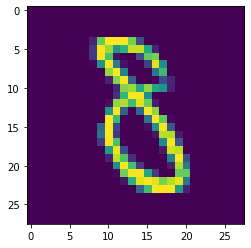

443


In [10]:
images2 = np.array([e.flatten() for e in images])
plt.imshow(images[120,0]*255)
print(labels[120])
plt.show()

ii = 0
for i in range(images2.shape[1]):
    if np.std(images2[:,i])>0.1:
        ii+= 1
print(ii)

In [4]:
X.max()

1.0

In [5]:
train_oof = np.zeros((X.shape[0], 10))
test_preds = 0
train_oof.shape

(42000, 10)

In [6]:
test = test.values/255

In [7]:
test.max()

1.0

In [8]:
n_splits = 5
kf = KFold(n_splits=n_splits, random_state=137)

for jj, (train_index, val_index) in enumerate(kf.split(X)):
    print("Fitting fold", jj+1)
    train_features = X[train_index]
    train_target = Y[train_index]
    
    val_features = X[val_index]
    val_target = Y[val_index]
    
    model = LogisticRegression(C=20, solver='lbfgs', multi_class='multinomial')
    model.fit(train_features, train_target)
    val_pred = model.predict_proba(val_features)
    train_oof[val_index] = val_pred
    print("Fold accuracy:", accuracy_score(val_target, np.argmax(val_pred, axis=1)))
    test_preds += model.predict_proba(test)/n_splits
    del train_features, train_target, val_features, val_target
    gc.collect()

Fitting fold 1


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Fold accuracy: 0.9171428571428571
Fitting fold 2


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Fold accuracy: 0.9185714285714286
Fitting fold 3


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Fold accuracy: 0.9134523809523809
Fitting fold 4


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Fold accuracy: 0.9151190476190476
Fitting fold 5


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Fold accuracy: 0.919404761904762


In [9]:
print(accuracy_score(Y, np.argmax(train_oof, axis=1)))

0.9167380952380952


In [10]:
preds = np.argmax(test_preds, axis=1)
preds

array([2, 0, 9, ..., 3, 9, 2])

In [11]:
submission['Label'] = preds
submission.to_csv('submission.csv', index=False)

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [12]:
np.save('test_preds', test_preds)
np.save('train_oof', train_oof)